In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random



import pandas as pd

file_path = "../web_service_dataset.csv"
df_original = pd.read_csv(file_path)






ImportError: DLL load failed while importing _cext: Impossibile trovare il modulo specificato.

In [ ]:
#%%
df_original

In [ ]:
#%%
# 3.1

from sklearn.preprocessing import StandardScaler

df_copy = df_original.copy()
# Define label (non-numerical) columns
label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

# Store the label columns in a separate DataFrame
df_labels = df_copy[label_columns]

# Drop label columns from the numerical dataset
df_copy = df_copy.drop(label_columns, axis=1)

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_copy)

# Create a new DataFrame with scaled numerical data
df_scaled = pd.DataFrame(scaled_data, columns=df_copy.columns)

# Add the label columns back to the scaled DataFrame
df_scaled = pd.concat([df_scaled, df_labels.reset_index(drop=True)], axis=1)

# Confirm scaling
print("Scaled data shape:", df_scaled.shape)

web_service_categories = df_scaled.groupby('web_service')['category'].nunique()

web_services_multiple_categories = web_service_categories[web_service_categories > 1]
print("Number of web services with multiple traffic categories:", len(web_services_multiple_categories))

most_categories_service = web_service_categories.idxmax()
most_categories_count = web_service_categories.max()

print("Web service with the most traffic categories:", most_categories_service)
print("Number of categories:", most_categories_count)


#%%
df_scaled
#%%

In [ ]:
# 3.2

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Select only columns of the features (PCA works only with features)
df_scaled_features = df_scaled.drop(label_columns, axis=1)

# creating a PCA
pca = PCA()
pca.fit(df_scaled_features)

# computing cumulative explained variance 
cumul_variance =  np.cumsum(pca.explained_variance_ratio_)

# make the plot of cumulative explained variance wrt number of components
# through this graph we can see how variance is increasing while adding new components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumul_variance) + 1), cumul_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# here we need to see how many components we need to save with this variance threshold 
threshold = 0.9

num_com = (cumul_variance >= threshold).argmax() + 1

print(f"Number of components to save 90% variance: {num_com}")

# so here we will create new PCA with fixed numbers of components
pca_selected = PCA(n_components=num_com)

# and transform data

pca_data = pca_selected.fit_transform(scaled_data)

# and here we will create a new dataset with different components and data
# columns is the main components

df_pca = pd.DataFrame(pca_data)


df_pca = pd.concat([df_pca, df_labels.reset_index(drop=True)], axis=1)

print("Transformed dataset shape:", df_pca.shape)


#%%
# 3.2


In [ ]:
df_pca
#%%
# 3.3
import matplotlib.pyplot as plt

# Randomly select an equal number of samples from each category

sample = 10000

sampled_data = (
    df_pca.groupby('category')
    .head(sample)
    .reset_index(drop=True)
)

pca_1 = sampled_data[0]  # first component 
pca_2 = sampled_data[1]  # second component 
categories = sampled_data['category']  # select labels

print(categories.unique())

# Create a scatter plot
plt.figure(figsize=(10, 8))

for category in categories.unique():
    category_data = sampled_data[sampled_data['category'] == category]
    plt.scatter(category_data[0], category_data[1], label=category, alpha=0.7)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of the first and second components (2 new features)')
plt.legend(title='Category', loc='best')

plt.show()

# Can you visually tell apart different categories? - I need to think about it

#%%


In [ ]:
# 3.4

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

features = df_pca.drop(label_columns, axis=1)
categories = df_pca['category']

### 1. K-Means Clustering ###
def kmeans_clustering(data, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
        print(f"K-Means with k={k}: Silhouette Score = {score:.3f}")
    
    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('K-Means: Silhouette Score vs. Number of Clusters')
    plt.grid()
    plt.show()
    
    # Optimal number of clusters
    optimal_k = np.argmax(silhouette_scores) + 2
    print(f"Optimal number of clusters (k): {optimal_k}")
    return optimal_k

optimal_k = kmeans_clustering(features)

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(features)

# Add K-Means labels to the dataset
df_pca['kmeans_cluster'] = kmeans_labels

# Plot clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    cluster_data = features[kmeans_labels == cluster]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering')
plt.legend()
plt.grid()
plt.show()

### 2. DBSCAN Clustering ###
def dbscan_clustering(data, eps_values, min_samples=5):
    silhouette_scores = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)
        
        # Silhouette Score only if there are at least 2 clusters
        if len(set(labels)) > 1:
            score = silhouette_score(data, labels)
            silhouette_scores.append(score)
            print(f"DBSCAN with eps={eps:.2f}: Silhouette Score = {score:.3f}")
        else:
            silhouette_scores.append(-1)  # Invalid clustering
    
    # Plot silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(eps_values, silhouette_scores, marker='o', linestyle='--')
    plt.xlabel('Epsilon (eps)')
    plt.ylabel('Silhouette Score')
    plt.title('DBSCAN: Silhouette Score vs. Epsilon')
    plt.grid()
    plt.show()
    
    # Optimal epsilon
    optimal_eps = eps_values[np.argmax(silhouette_scores)]
    print(f"Optimal epsilon (eps): {optimal_eps}")
    return optimal_eps

eps_range = np.linspace(0.1, 1.0, 10)  # Range of eps values to test
optimal_eps = dbscan_clustering(features, eps_range)

# Fit final DBSCAN model
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan_labels = dbscan_final.fit_predict(features)

# Add DBSCAN labels to the dataset
df_pca['dbscan_cluster'] = dbscan_labels

# Plot clusters
plt.figure(figsize=(8, 6))
unique_labels = set(dbscan_labels)
for label in unique_labels:
    cluster_data = features[dbscan_labels == label]
    label_name = f'Cluster {label}' if label != -1 else 'Noise'
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=label_name)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 3.1

from sklearn.preprocessing import StandardScaler

df_copy = df_original.copy()
# Define label (non-numerical) columns
label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

# Store the label columns in a separate DataFrame
df_labels = df_copy[label_columns]

# Drop label columns from the numerical dataset
df_copy = df_copy.drop(label_columns, axis=1)

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_copy)

# Create a new DataFrame with scaled numerical data
df_scaled = pd.DataFrame(scaled_data, columns=df_copy.columns)

# Add the label columns back to the scaled DataFrame
df_scaled = pd.concat([df_scaled, df_labels.reset_index(drop=True)], axis=1)

# Confirm scaling
print("Scaled data shape:", df_scaled.shape)

web_service_categories = df_scaled.groupby('web_service')['category'].nunique()

web_services_multiple_categories = web_service_categories[web_service_categories > 1]
print("Number of web services with multiple traffic categories:", len(web_services_multiple_categories))

most_categories_service = web_service_categories.idxmax()
most_categories_count = web_service_categories.max()

print("Web service with the most traffic categories:", most_categories_service)
print("Number of categories:", most_categories_count)




In [ ]:
df_scaled
# 3.2


In [ ]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Select only columns of the features (PCA works only with features)
df_scaled_features = df_scaled.drop(label_columns, axis=1)

# creating a PCA
pca = PCA()
pca.fit(df_scaled_features)

# computing cumulative explained variance 
cumul_variance = np.cumsum(pca.explained_variance_ratio_)

# make the plot of cumulative explained variance wrt number of components
# through this graph we can see how variance is increasing while adding new components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumul_variance) + 1), cumul_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# here we need to see how many components we need to save with this variance threshold 
threshold = 0.9

num_com = (cumul_variance >= threshold).argmax() + 1

print(f"Number of components to save 90% variance: {num_com}")

# so here we will create new PCA with fixed numbers of components
pca_selected = PCA(n_components=num_com)

# and transform data

pca_data = pca_selected.fit_transform(scaled_data)

# and here we will create a new dataset with different components and data
# columns is the main components

df_pca = pd.DataFrame(pca_data)

df_pca = pd.concat([df_pca, df_labels.reset_index(drop=True)], axis=1)

print("Transformed dataset shape:", df_pca.shape)



In [ ]:
# 3.2
df_pca

In [ ]:
# 3.3
import matplotlib.pyplot as plt

# Randomly select an equal number of samples from each category

sample = 10000

sampled_data = (
      df_pca.groupby('category')
      .head(sample)
      .reset_index(drop=True)
)

pca_1 = sampled_data[0]  # first component 
pca_2 = sampled_data[1]  # second component 
categories = sampled_data['category']  # select labels

print(categories.unique())

# Create a scatter plot
plt.figure(figsize=(10, 8))

for category in categories.unique():
      category_data = sampled_data[sampled_data['category'] == category]
      plt.scatter(category_data[0], category_data[1], label=category, alpha=0.7)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Scatter plot of the first and second components (2 new features)')
plt.legend(title='Category', loc='best')

plt.show()

# Can you visually tell apart different categories? - I need to think about it



In [ ]:
# 3.4

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

features = df_pca.drop(label_columns, axis=1)
categories = df_pca['category']


### 1. K-Means Clustering ###
def kmeans_clustering(data, max_clusters=10):
      silhouette_scores = []
      for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(data)
            score = silhouette_score(data, labels)
            silhouette_scores.append(score)
            print(f"K-Means with k={k}: Silhouette Score = {score:.3f}")

      # Plot silhouette scores
      plt.figure(figsize=(8, 6))
      plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
      plt.xlabel('Number of Clusters (k)')
      plt.ylabel('Silhouette Score')
      plt.title('K-Means: Silhouette Score vs. Number of Clusters')
      plt.grid()
      plt.show()

      # Optimal number of clusters
      optimal_k = np.argmax(silhouette_scores) + 2
      print(f"Optimal number of clusters (k): {optimal_k}")
      return optimal_k


optimal_k = kmeans_clustering(features)

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans_final.fit_predict(features)

# Add K-Means labels to the dataset
df_pca['kmeans_cluster'] = kmeans_labels

# Plot clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
      cluster_data = features[kmeans_labels == cluster]
      plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {cluster}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering')
plt.legend()
plt.grid()
plt.show()


### 2. DBSCAN Clustering ###
def dbscan_clustering(data, eps_values, min_samples=5):
      silhouette_scores = []
      for eps in eps_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            # Silhouette Score only if there are at least 2 clusters
            if len(set(labels)) > 1:
                  score = silhouette_score(data, labels)
                  silhouette_scores.append(score)
                  print(f"DBSCAN with eps={eps:.2f}: Silhouette Score = {score:.3f}")
            else:
                  silhouette_scores.append(-1)  # Invalid clustering

      # Plot silhouette scores
      plt.figure(figsize=(8, 6))
      plt.plot(eps_values, silhouette_scores, marker='o', linestyle='--')
      plt.xlabel('Epsilon (eps)')
      plt.ylabel('Silhouette Score')
      plt.title('DBSCAN: Silhouette Score vs. Epsilon')
      plt.grid()
      plt.show()

      # Optimal epsilon
      optimal_eps = eps_values[np.argmax(silhouette_scores)]
      print(f"Optimal epsilon (eps): {optimal_eps}")
      return optimal_eps


eps_range = np.linspace(0.1, 1.0, 10)  # Range of eps values to test
optimal_eps = dbscan_clustering(features, eps_range)

# Fit final DBSCAN model
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan_labels = dbscan_final.fit_predict(features)

# Add DBSCAN labels to the dataset
df_pca['dbscan_cluster'] = dbscan_labels

# Plot clusters
plt.figure(figsize=(8, 6))
unique_labels = set(dbscan_labels)
for label in unique_labels:
      cluster_data = features[dbscan_labels == label]
      label_name = f'Cluster {label}' if label != -1 else 'Noise'
      plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=label_name)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.grid()
plt.show()


In [2]:
df_original

,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,...,b_std_dev_ps,b_flowStart,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,category,web_service
0,192.168.121.1,67,172.16.255.185,67,UDP,22,7620,328,394,346.363636,...,2.000000,1.555955e+09,1.555955e+09,1.554399e+12,1.035380e-02,198.657965,51.689181,84.916348,Network,DHCP
1,192.168.121.1,67,172.16.255.186,67,UDP,17,5670,328,354,333.529412,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,Network,DHCP
2,192.168.121.1,67,172.16.255.185,67,UDP,43,15124,328,394,351.720930,...,1.332347,1.555964e+09,1.555965e+09,1.554409e+12,2.233195e-02,340.268454,89.927588,124.270745,Network,DHCP
3,192.168.121.1,67,172.16.255.186,67,UDP,30,10086,328,352,336.200000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,Network,DHCP
4,192.168.121.1,0,10.130.1.166,0,ICMP,1,56,56,56,56.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,Network,ICMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704834,192.168.128.252,137,172.16.255.186,137,UDP,9,702,78,78,78.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,System,NetBIOS
2704835,192.168.128.252,138,172.16.255.185,138,UDP,3,687,229,229,229.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,System,NetBIOS
2704836,192.168.128.252,138,172.16.255.186,138,UDP,3,687,229,229,229.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,System,NetBIOS
2704837,192.168.128.252,49879,108.177.11.188,5228,TCP,75,3520,40,66,46.933333,...,4.228907,1.559770e+09,1.559771e+09,1.558211e+12,1.150203e-02,90.155711,44.999017,14.822745,Web,Google


In [16]:
# 3.1

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
df_copy = df_original.copy()
# Define label (non-numerical) columns
label_columns = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'category', 'web_service', 'proto']

# Store the label columns in a separate DataFrame
df_labels = df_copy[label_columns]

# Drop label columns from the numerical dataset
df_copy = df_copy.drop(label_columns, axis=1)

# Standardize the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_copy)

# Create a new DataFrame with scaled numerical data
df_scaled = pd.DataFrame(scaled_data, columns=df_copy.columns)

# Add the label columns back to the scaled DataFrame
df_scaled = pd.concat([df_scaled, df_labels.reset_index(drop=True)], axis=1)

# Confirm scaling
print("Scaled data shape:", df_scaled.shape)


Scaled data shape: (2704839, 46)


In [17]:
df_scaled

,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,std_dev_ps,flowStart,flowEnd,flowDuration,min_piat,...,b_max_piat,b_avg_piat,b_std_dev_piat,src_ip,src_port,dst_ip,dst_port,category,web_service,proto
0,-0.017654,-0.018223,4.478531,-0.290998,0.344931,-0.466290,-0.800156,-0.799133,9.045503,-0.055404,...,2.987091,1.279851,4.959656,192.168.121.1,67,172.16.255.185,67,Network,DHCP,UDP
1,-0.018969,-0.018580,4.478531,-0.304607,0.307364,-0.495915,-0.800156,-0.799133,9.045503,-0.055098,...,-0.258028,-0.111224,-0.248445,192.168.121.1,67,172.16.255.186,67,Network,DHCP,UDP
2,-0.012135,-0.016847,4.478531,-0.290998,0.360613,-0.464258,-0.793921,-0.793053,7.670823,-0.055407,...,5.300328,2.308934,7.373345,192.168.121.1,67,172.16.255.185,67,Network,DHCP,UDP
3,-0.015552,-0.017770,4.478531,-0.305287,0.315181,-0.494202,-0.793921,-0.793053,7.670822,-0.054947,...,-0.258028,-0.111224,-0.248445,192.168.121.1,67,172.16.255.186,67,Network,DHCP,UDP
4,-0.023174,-0.019609,-0.037019,-0.405993,-0.505003,-0.512978,-0.792105,-0.792138,-0.294316,-0.055414,...,-0.258028,-0.111224,-0.248445,192.168.121.1,0,10.130.1.166,0,Network,ICMP,ICMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704834,-0.021071,-0.019491,0.328210,-0.398508,-0.440606,-0.512978,1.569307,1.569882,5.082190,-0.032670,...,-0.258028,-0.111224,-0.248445,192.168.128.252,137,172.16.255.186,137,System,NetBIOS,UDP
2704835,-0.022648,-0.019494,2.835004,-0.347135,0.001392,-0.512978,1.569058,1.569918,7.602423,21.841174,...,-0.258028,-0.111224,-0.248445,192.168.128.252,138,172.16.255.185,138,System,NetBIOS,UDP
2704836,-0.022648,-0.019494,2.835004,-0.347135,0.001392,-0.512978,1.569058,1.569918,7.602423,21.841178,...,-0.258028,-0.111224,-0.248445,192.168.128.252,138,172.16.255.186,138,System,NetBIOS,UDP
2704837,-0.003724,-0.018974,-0.302639,-0.402591,-0.531542,-0.500497,1.569050,1.570078,9.092950,-0.055064,...,1.214685,1.099803,0.660666,192.168.128.252,49879,108.177.11.188,5228,Web,Google,TCP


In [18]:
# 3.1

# Group the data by 'web_service' and count the unique 'category' values
web_service_category_counts = df_original.groupby('web_service')['category'].nunique()

# Filter web services that have more than 1 traffic category
multiple_categories = web_service_category_counts[web_service_category_counts > 1]

# Display how many web services have multiple categories
print(f"Number of web services with multiple traffic categories: {len(multiple_categories)}")

# Identify the web service with the most traffic categories
web_service_most_categories = multiple_categories.idxmax()
most_categories_count = multiple_categories.max()

print(f"The web service with the most traffic categories is '{web_service_most_categories}' "
      f"with {most_categories_count} categories.")

Number of web services with multiple traffic categories: 5
The web service with the most traffic categories is 'DNS' with 4 categories.


In [9]:
num_different_wservices = df_original['web_service'].nunique()
num_different_wservices

141

In [28]:
# 3.2
# Select only columns of the features
df_scaled_features = df_scaled.drop(label_columns, axis =1)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Nuovo Utente\AppData\Local\Temp\ipykernel_6796\2098115749.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'15 PCs explain {round(perc_cumul_exp_var[14], 2)}% of $\sigma^2$')


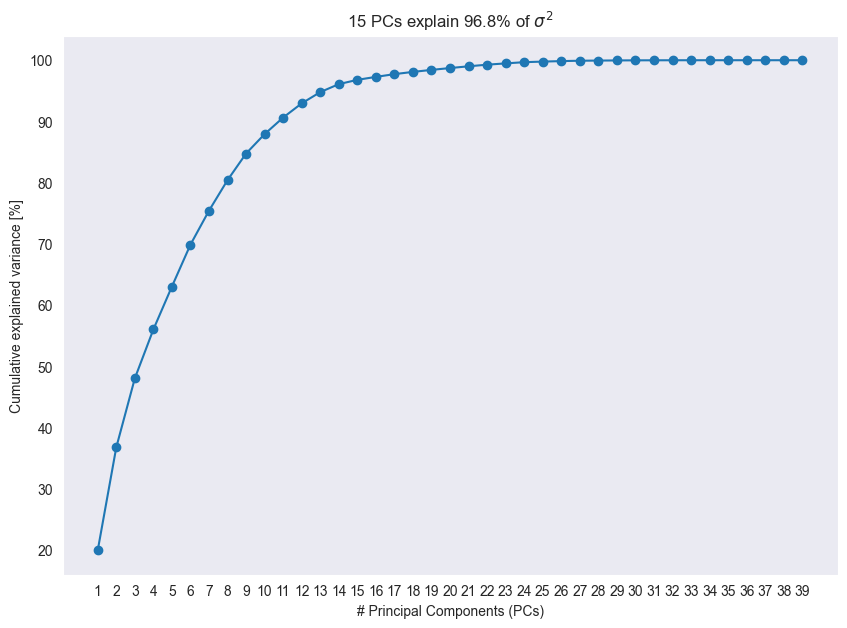

In [40]:
# 3.2
# PCA must be initialized with a random state to initialize the space
pca = PCA(random_state=15)

# .fit() is used to compute the new dimensions with number of features from 1 to the number of original features
pca.fit(df_scaled_features)

# describe how much of the dataset variability is indicated by a given amount of features
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(10, 7))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks(range(len(perc_cumul_exp_var)), range(1, len(perc_cumul_exp_var) + 1))
plt.grid()
plt.title(f'15 PCs explain {round(perc_cumul_exp_var[14], 2)}% of $\sigma^2$')
# plt.tight_layout()
plt.show()


We will choose 15 components because we can clearly see that the cumulative explained variance flattens.
 Moreover, the cumulative ecplained variance with 15 components has already a nearly optimal result (96,8%).


In [33]:
print(perc_cumul_exp_var[14])

96.79613119664336


In [45]:
# 3.2

pca = PCA(n_components=20, random_state=15) 

pca.fit(df_scaled_features)
explained_variance = pca.explained_variance_ratio_ 
cumul_exp_var = np.cumsum(explained_variance) 
perc_cumul_exp_var = cumul_exp_var*100 
# print(perc_cumul_exp_var[-1])

# Transform the dataset
pca_result = pca.transform(df_scaled_features)
df_pca_result = pd.DataFrame(pca_result, columns=[f'PC{i}' for i in range(20)])


In [43]:
df_pca_result

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,10.265629,-3.125388,0.246477,-1.433726,0.149088,3.404355,-3.249564,6.304175,-6.362348,-0.293745,1.463653,6.081930,4.101982,3.082914,0.217576
1,8.231046,-4.002364,0.741956,1.563438,-4.457090,3.671469,-5.512554,3.269379,-3.345849,-0.150270,1.111530,8.640272,0.918632,-0.186000,0.424815
2,10.323759,-2.867958,0.072356,-1.931808,1.409580,3.863603,-2.971120,7.596938,-5.255861,-0.344581,1.856280,3.188270,6.011684,3.262620,0.067010
3,7.067660,-3.565378,0.664477,1.493444,-4.182588,3.713640,-5.256524,3.688709,-2.682819,-0.146886,1.109034,7.299990,0.490484,-0.152996,0.243744
4,-1.269196,-1.790586,0.413616,0.031567,-2.142481,0.259298,-1.818365,-0.301036,2.216678,0.215610,-0.645229,-0.194663,0.608509,0.001002,-0.397789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704834,14.402512,-6.404638,0.440342,3.441146,1.544169,3.433249,-8.556845,0.944285,-2.457660,0.858604,-3.880305,1.192587,-8.420294,-0.667751,-0.104994
2704835,23.377368,-12.433620,1.734340,8.361292,-15.610620,-9.494147,3.132589,-13.582214,-13.257483,-0.634814,2.275672,-0.241189,5.155879,-0.157510,0.359735
2704836,23.377366,-12.433620,1.734340,8.361292,-15.610622,-9.494149,3.132592,-13.582217,-13.257484,-0.634814,2.275674,-0.241188,5.155884,-0.157509,0.359735
2704837,6.404195,-2.150704,0.304085,1.500264,3.387908,2.171169,-2.934419,-0.614924,-2.907800,-0.173370,1.223082,9.236224,3.828607,-0.086543,1.108738


C:\Users\Nuovo Utente\AppData\Local\Temp\ipykernel_6796\1846337316.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_pca_result.groupby('category').apply(lambda x: x.sample(min(len(x), num_samples_per_category)))


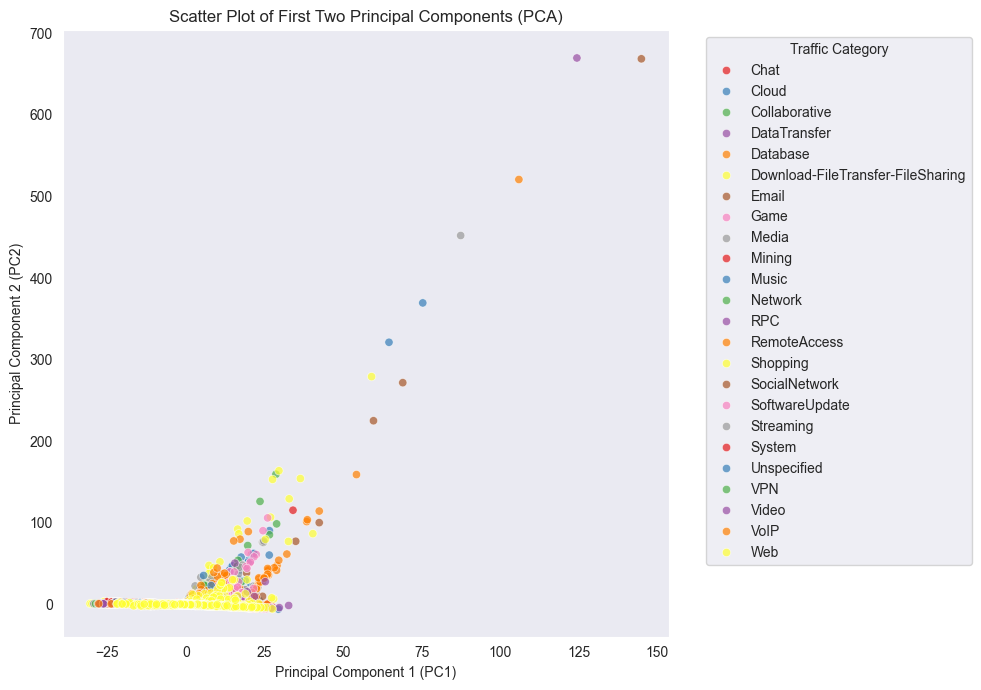

In [47]:
# 3.3

categories = df_original['category']
df_pca_result['category'] = categories

# Step 5: Randomly sample the same number of points from each category
num_samples_per_category = 50000 
sampled_df = df_pca_result.groupby('category').apply(lambda x: x.sample(min(len(x), num_samples_per_category)))
sampled_df.reset_index(drop=True, inplace=True)


# Scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=sampled_df, x='PC1', y='PC2', hue='category', palette='Set1', alpha=0.7)
plt.title("Scatter Plot of First Two Principal Components (PCA)")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title='Traffic Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


Different traffic categories are difficult to tell apart.